In [1]:
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import matplotlib.pyplot as plt
import sys
import copy
%matplotlib inline

In [2]:
# policy evaluation with Monte Carlo
def eval_policy(policy, eval_env, eval_episodes=10):
        avg_reward = 0.0
        for _ in range(eval_episodes):
            state, _ = eval_env.reset()
            done = False
            step = 0
            while not done:
                action = policy.select_action(np.array(state))
                state, reward, terminated, _, _ = eval_env.step(action)
                avg_reward += reward
                step += 1
                done = terminated
        avg_reward /= eval_episodes

        print("---------------------------------------")
        print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
        print("---------------------------------------")
        return avg_reward

In [3]:
# Replay buffer
class ReplayBuffer(object):
    def __init__(self, state_dim, action_dim, max_size=int(1e6)):
        self.max_size = max_size
        self.ptr = 0
        self.size = 0

        self.state = np.zeros((max_size, state_dim))
        self.action = np.zeros((max_size, action_dim))
        self.next_state = np.zeros((max_size, state_dim))
        self.reward = np.zeros((max_size, 1))
        self.not_done = np.zeros((max_size, 1))

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    def add(self, state, action, next_state, reward, done):
        self.state[self.ptr] = state
        self.action[self.ptr] = action
        self.next_state[self.ptr] = next_state
        self.reward[self.ptr] = reward
        self.not_done[self.ptr] = 1. - done

        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)


    def sample(self, batch_size):
        ind = np.random.randint(0, self.size, size=batch_size)

        return (
            torch.FloatTensor(self.state[ind]).to(self.device),
            torch.FloatTensor(self.action[ind]).to(self.device),
            torch.FloatTensor(self.next_state[ind]).to(self.device),
            torch.FloatTensor(self.reward[ind]).to(self.device),
            torch.FloatTensor(self.not_done[ind]).to(self.device)
        )

In [4]:
import sys
sys.path.append('../models/simulator_and_related_models/')
from env import simulator

In [5]:
# simulator()

In [6]:
# Implementation of Twin Delayed Deep Deterministic Policy Gradients (TD3)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device = torch.device("cpu")

# if torch.cuda.is_available():
#     device = torch.device("cuda")
# elif torch.backends.mps.is_available():
#     device = torch.device("mps")

print(device)

class Actor_TD3(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor_TD3, self).__init__()

        self.l1 = nn.Linear(state_dim, 256)
        self.l2 = nn.Linear(256, 256)
        self.l3 = nn.Linear(256, action_dim)

        self.max_action = max_action


    def forward(self, state):
        a = F.relu(self.l1(state))
        a = F.relu(self.l2(a))
        return self.max_action * torch.tanh(self.l3(a))


class Critic_TD3(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic_TD3, self).__init__()

        # Q1 architecture
        self.l1 = nn.Linear(state_dim + action_dim, 256)
        self.l2 = nn.Linear(256, 256)
        self.l3 = nn.Linear(256, 1)

        # Q2 architecture
        self.l4 = nn.Linear(state_dim + action_dim, 256)
        self.l5 = nn.Linear(256, 256)
        self.l6 = nn.Linear(256, 1)


    def forward(self, state, action):
        sa = torch.cat([state, action], 1)
        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = self.l3(q1)

        q2 = F.relu(self.l4(sa))
        q2 = F.relu(self.l5(q2))
        q2 = self.l6(q2)
        return q1, q2


    def Q1(self, state, action):
        sa = torch.cat([state, action], 1)

        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = self.l3(q1)
        return q1


class TD3(object):
    def __init__(
        self,
        state_dim,
        action_dim,
        max_action,
        discount=0.99,
        tau=0.005,
        policy_noise=0.2,
        noise_clip=0.5,
        policy_freq=2
    ):

        self.actor = Actor_TD3(state_dim, action_dim, max_action).to(device)
        self.actor_target = copy.deepcopy(self.actor)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=3e-4)

        self.critic = Critic_TD3(state_dim, action_dim).to(device)
        self.critic_target = copy.deepcopy(self.critic)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=3e-4)

        self.max_action = max_action
        self.discount = discount
        self.tau = tau
        self.policy_noise = policy_noise
        self.noise_clip = noise_clip
        self.policy_freq = policy_freq
        self.total_it = 0


    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.actor(state).cpu().data.numpy().flatten()


    def train(self, replay_buffer, batch_size=256):
        self.total_it += 1

        # print(self.total_it)
        
        # Sample replay buffer
        state, action, next_state, reward, not_done = replay_buffer.sample(batch_size)

        with torch.no_grad():
            # Select action according to policy and add clipped noise
            noise = (
                torch.randn_like(action) * self.policy_noise
            ).clamp(-self.noise_clip, self.noise_clip)

            next_action = (
                self.actor_target(next_state) + noise
            ).clamp(-self.max_action, self.max_action)

            # Compute the target Q value
            target_Q1, target_Q2 = self.critic_target(next_state, next_action)

            # Compute the target_Q here
            target_Q = torch.min(target_Q1, target_Q2)
            target_Q = reward + not_done * self.discount * target_Q

        # Get current Q estimates
        current_Q1, current_Q2 = self.critic(state, action)

        # Compute critic loss
        critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

        # Optimize the critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Delayed policy updates
        if self.total_it % self.policy_freq == 0:

            # Compute actor loss
            # pi = self.actor(state)
            # actor_loss = -self.critic.Q1(state, pi).mean() + F.mse_loss(pi, action)
            actor_loss = -self.critic.Q1(state, self.actor(state)).mean()

            # Optimize the actor
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # Update the frozen target models
            for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

            for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)



cpu


In [7]:
def init_flags():

        flags = {
                "env": "Pendulum-v1",
                "seed":0,
                "start_timesteps": 2e4,
                "max_timesteps": 5e4,
                "expl_noise": 0.01,
                "batch_size": 256,
                "discount":0.99,
                "tau": 0.005,
                "policy_noise": 0.05,
                "noise_clip":0.5,
                "policy_freq": 2,
                "save_model": "store_true"
        }

        return flags

def main(policy_name = 'TD3'):

        args = init_flags()
        
        def reward(self, penalty, action):
            extra = 0
            if self.done == 1 and self.correct_solution == 0:
                extra = -8
            if action == 2:
                penalty = -5
            return self.prob_count * 13 + self.listen_to_feedback_count * 10 + extra + penalty + self.convo_turn + self.progress_delta
        
        env = simulator(reward)

        env.reset()
        torch.manual_seed(args["seed"])
        np.random.seed(args["seed"])

        state_dim = 7
        action_dim = 1
        max_action = 3
        kwargs = {
                "state_dim": state_dim,
                "action_dim": action_dim,
                "max_action": max_action,
                "discount": args["discount"],
                "tau": args["tau"],}
        if policy_name == "TD3":
                # Target policy smoothing is scaled wrt the action scale
                kwargs["policy_noise"] = args["policy_noise"] * max_action
                kwargs["noise_clip"] = args["noise_clip"] * max_action
                kwargs["policy_freq"] = args["policy_freq"]
                policy = TD3(**kwargs)
        elif policy_name == "SAC":
                policy = SAC(**kwargs)

        replay_buffer = ReplayBuffer(state_dim, action_dim)
        evaluations = [eval_policy(policy, env)]
        state, _ = env.reset()
        done = False
        episode_reward = 0
        episode_timesteps = 0
        episode_num = 0

        for t in range(int(args["max_timesteps"])):
            episode_timesteps += 1

            # Select action randomly or according to policy
            if t < args["start_timesteps"]:
                action = np.random.choice(env.action_space)
            else:
                action = (
                    policy.select_action(np.array(state))
                    + np.random.normal(0, max_action * args["expl_noise"], size=action_dim)
                ).clip(-max_action, max_action)

            # Perform action
            next_state, reward, terminated, _, _ = env.step(action)
            done = terminated
            done_bool = float(done) if episode_timesteps < env._max_episode_steps else 0

            # Store data in replay buffer
            replay_buffer.add(state, action, next_state, reward, done_bool)

            state = next_state
            episode_reward += reward

            # Train agent after collecting sufficient data
            if t >= args["start_timesteps"]:
                policy.train(replay_buffer, args["batch_size"])

            if episode_num % 10 == 0:
                # +1 to account for 0 indexing. +0 on ep_timesteps since it will increment +1 even if done=True
                    print(f"Total T: {t+1} Episode Num: {episode_num+1} Episode T: {episode_timesteps} Reward: {episode_reward:.3f}")

            if done:
                evaluations.append(episode_reward)

                # Reset environment
                state, _ = env.reset()
                done = False
                episode_reward = 0
                episode_timesteps = 0
                episode_num += 1

        return policy,evaluations


---------------------------------------
Evaluation over 10 episodes: 33.400
---------------------------------------
Total T: 1 Episode Num: 1 Episode T: 1 Reward: 102.000
Total T: 15 Episode Num: 11 Episode T: 1 Reward: 3.000
Total T: 27 Episode Num: 21 Episode T: 1 Reward: 126.000
Total T: 37 Episode Num: 31 Episode T: 1 Reward: 11.000
Total T: 38 Episode Num: 31 Episode T: 2 Reward: 134.000
Total T: 54 Episode Num: 41 Episode T: 1 Reward: 3.000
Total T: 67 Episode Num: 51 Episode T: 1 Reward: 17.000
Total T: 68 Episode Num: 51 Episode T: 2 Reward: 145.000
Total T: 80 Episode Num: 61 Episode T: 1 Reward: 132.000
Total T: 91 Episode Num: 71 Episode T: 1 Reward: 49.000
Total T: 104 Episode Num: 81 Episode T: 1 Reward: 126.000
Total T: 118 Episode Num: 91 Episode T: 1 Reward: 132.000
Total T: 131 Episode Num: 101 Episode T: 1 Reward: 132.000
Total T: 142 Episode Num: 111 Episode T: 1 Reward: 49.000
Total T: 155 Episode Num: 121 Episode T: 1 Reward: 126.000
Total T: 166 Episode Num: 131 E

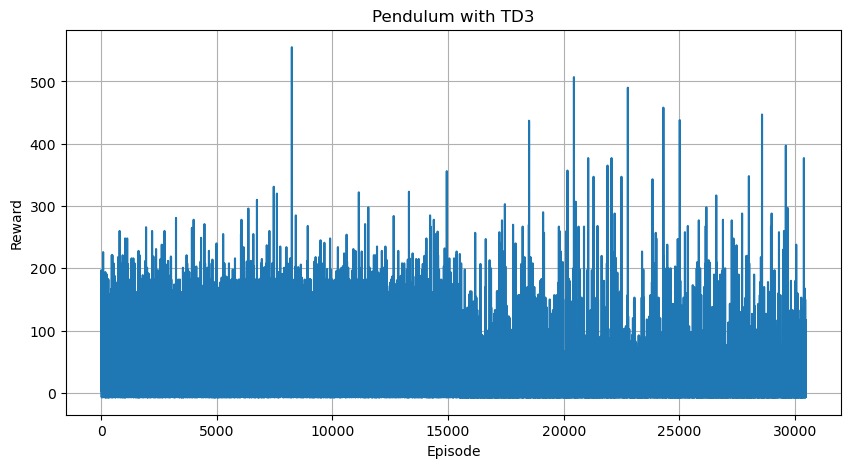

In [8]:
policy, evaluation_td3 = main(policy_name = 'TD3')
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(evaluation_td3)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Pendulum with TD3')
plt.grid()
plt.show()

In [9]:
def evaluate_policy(policy, env, seed=42):
    env_test = env
    state, _ = env_test.reset()
    done = False
    total_reward = 0
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0)
        action = policy.select_action(state)
        next_state, reward, done, _, _ = env_test.step(action)
        state = next_state
        total_reward += reward
    return total_reward

In [10]:
def reward(self, penalty, action):
    extra = 0
    if self.done == 1 and self.correct_solution == 0:
        extra = -8
    if action == 2:
        penalty = -5
    return self.prob_count * 13 + self.listen_to_feedback_count * 10 + extra + penalty + self.convo_turn + self.progress_delta

env = simulator(reward)

rewards = [evaluate_policy(policy,env) for i in range(10000)]

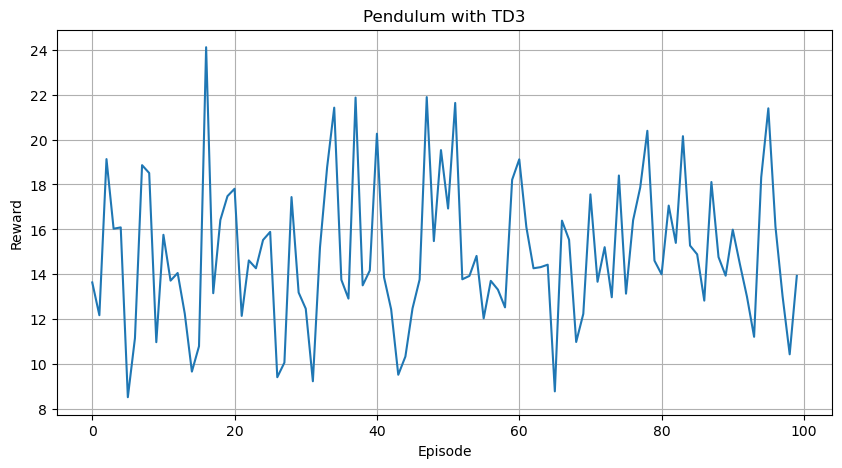

In [11]:
import matplotlib.pyplot as plt

rewards_average = []
for i in range(0,10000,100):
    rewards_average.append(np.mean(rewards[i: i+100]))


plt.figure(figsize=(10, 5))
plt.plot(rewards_average)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Pendulum with TD3')
plt.grid()
plt.show()

In [17]:
import pickle
dbfile = open('TD3_rewards_average.pkl', 'wb')
pickle.dump(rewards_average, dbfile)
dbfile.close()

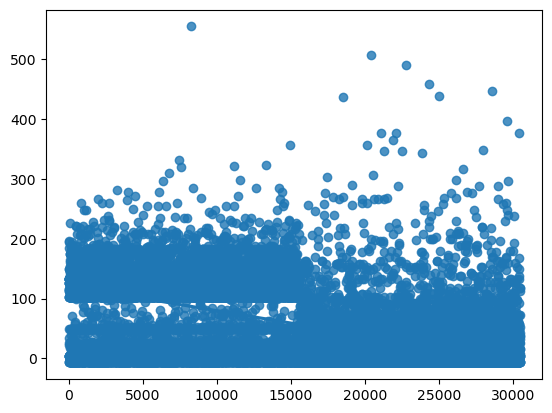

In [13]:
evaluation_td3

import numpy as np
import seaborn as sns

sns.regplot(x=np.arange(len(evaluation_td3)), y=evaluation_td3)
plt.show()

In [14]:
# reward 
# reward = self.correct_solution * 5 + penalty + (1 + self.done) # TD3 starts to learn something

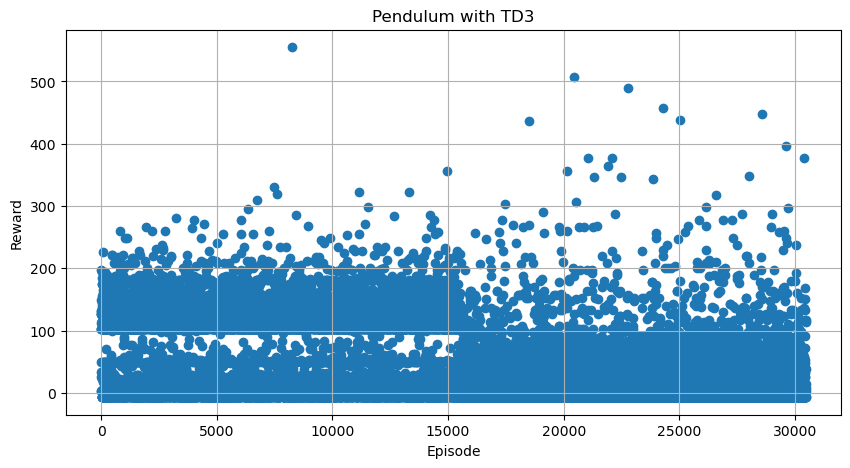

In [15]:
plt.figure(figsize=(10, 5))
plt.scatter(np.arange(len(evaluation_td3)), evaluation_td3)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Pendulum with TD3')
plt.grid()
plt.show()